### Notebook to develop threshold for modified NDSI (MNDSI) for identifying snow in PlanetScope 4-band imagery
Rainey Aberle

December 2021

In [1]:
# Import packages
import os
import glob
import numpy as np
import rasterio as rio
from rasterio.plot import show
import geopandas as gpd
from shapely.geometry.polygon import Polygon
import earthpy.spatial as es
import scipy
import matplotlib.pyplot as plt

# base directory
basepath = '/Users/raineyaberle/Research/PhD/Wolverine/'
# image directory
impath = basepath+'imagery/Planet/2021-04-20_2021-08-25/SR-stitched/'
# output folder
outpath = basepath+'imagery/Planet/2021-04-20_2021-08-25/MNDSI'

In [2]:
### Area of Interest (AOI) ###
# Read in shapefile with AOI polygon
fn = basepath+'GIS_data/wolverine_RGI.shp'
AOI = gpd.read_file(fn)
print('Original shapefile CRS:',AOI.crs)

# Reproject to imagery CRS if necessary
AOI = AOI.to_crs(32606)

# print information
print('Reprojected shapefile CRS: ',AOI.crs)
print('Shapefile bounds:',AOI.boundary)

Original shapefile CRS: epsg:4326
Reprojected shapefile CRS:  epsg:32606
Shapefile bounds: 0    MULTILINESTRING ((393342.531 6698475.452, 3933...
dtype: geometry


In [3]:
### Load image, digitized snow line, & transect ###
# image
os.chdir(impath) # change directory
im_name = glob.glob('20210821.tif')
print('Image: ',im_name[0])
print('')

# snowline
sl_fn = basepath+'imagery/Planet/2021-04-20_2021-08-25/digitized_snowline_picks/20210821.shp'
sl = gpd.read_file(sl_fn) # snowline
print('Snowline CRS: ',sl.crs)
# Reproject to imagery CRS if necessary
sl = sl.to_crs(32606)
# print information
print('Reprojected shapefile CRS: ',sl.crs)
print('Shapefile bounds:',sl.boundary)
print('')

# transect
ts_fn = basepath+'imagery/Planet/2021-04-20_2021-08-25/digitized_snowline_picks/20210821_transect.shp'
ts = gpd.read_file(ts_fn) # snowline
print('Transect CRS: ',ts.crs)
# Reproject to imagery CRS if necessary
ts = ts.to_crs(32606)
# print information
print('Reprojected shapefile CRS: ',ts.crs)
print('Shapefile bounds:',ts.boundary)

Image:  20210821.tif

Snowline CRS:  epsg:4326
Reprojected shapefile CRS:  epsg:32606
Shapefile bounds: 0    MULTIPOINT (393148.827 6699387.404, 396547.495...
dtype: geometry

Transect CRS:  epsg:4326
Reprojected shapefile CRS:  epsg:32606
Shapefile bounds: 0    MULTIPOINT (395676.063 6699864.600, 395407.264...
dtype: geometry


/Users/raineyaberle/opt/anaconda3/lib/python3.8/site-packages/earthpy/spatial.py:105: RuntimeWarning: invalid value encountered in true_divide
  n_diff = (b1 - b2) / (b1 + b2)
/Users/raineyaberle/opt/anaconda3/lib/python3.8/site-packages/earthpy/spatial.py:105: RuntimeWarning: overflow encountered in ushort_scalars
  n_diff = (b1 - b2) / (b1 + b2)


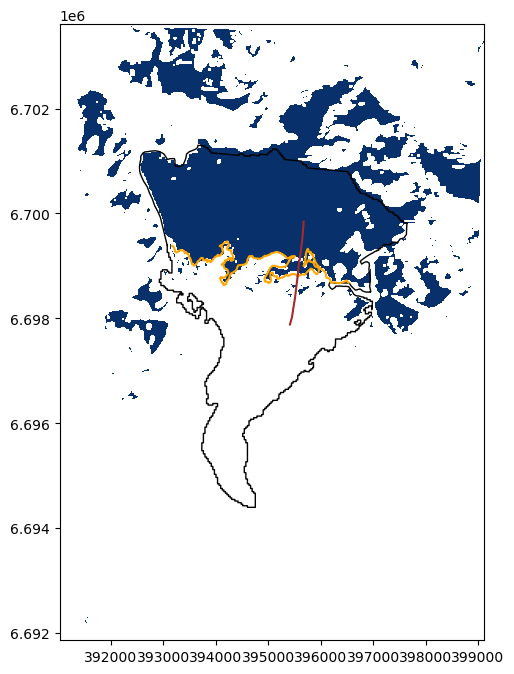

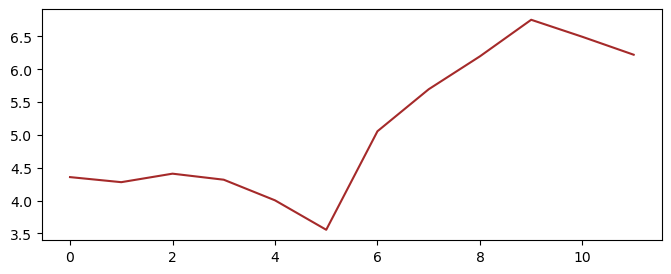

In [69]:
### Identify snow ###

# function to calculate MNDSI
def calculate_mndsi(nir,red):
    mndsi = es.normalized_diff(nir, red)
    return mndsi

# open image
im = rio.open(im_name[0])

# define bands, convert to TOA reflectance
#refl_coeff = 5.12134605626e-05 # from image metadata
blue = im.read(1)#*refl_coeff
green = im.read(2)#*refl_coeff
red = im.read(3)#*refl_coeff
nir = im.read(4)#*refl_coeff
# compute MNDSI
mndsi = calculate_mndsi(nir,red) 

# threshold MNDSI to determine snow cover
thresh_snow = 5.6
thresh_earth = 1.5
snow = np.where((mndsi<thresh_snow) & (mndsi>thresh_earth),1,np.nan)

### interpolate MNDSI along snowline and transect 
## snowline
# extract points from geometry
sl_pts = [i for i in sl.geometry]
sl_x,sl_y = sl_pts[0].coords.xy
sl_coords = np.dstack((sl_x,sl_y)).tolist()
# sample raster values at coordinates
sl_rv = [x for x in im.sample(sl_coords[0])]
# calculate MNDSI at points
sl_mndsi=[]
for s in sl_rv:
    sl_mndsi = sl_mndsi + [calculate_mndsi(s[3],s[2])]
## transect
# extract points from geometry
ts_pts = [i for i in ts.geometry]
ts_x,ts_y = ts_pts[0].coords.xy
ts_coords = np.dstack((ts_x,ts_y)).tolist()
# sample raster values at coordinates
ts_rv = [x for x in im.sample(ts_coords[0])]
# calculate MNDSI at points
ts_mndsi=[]
for s in ts_rv:
    ts_mndsi = ts_mndsi + [calculate_mndsi(s[3],s[2])]

# plot 
fig1, ax1 = plt.subplots(1,1,figsize=(8,8))
# MNDSI, snow, snowline, and transect locations
#show(mndsi, transform=im.transform, cmap='Purples', clim=(0,1), ax=ax1)
show(snow, transform=im.transform, cmap='Blues', clim=(0,1), ax=ax1)
AOI.plot(ax=ax1,facecolor='none',edgecolor='black')
sl.plot(ax=ax1,color='orange')
ts.plot(ax=ax1,color='brown')
# MNDSI values along transect
fig2, ax3 = plt.subplots(1,1,figsize=(8,3))
ax3.plot(ts_mndsi, color='brown', label='MNDSI')
plt.show()

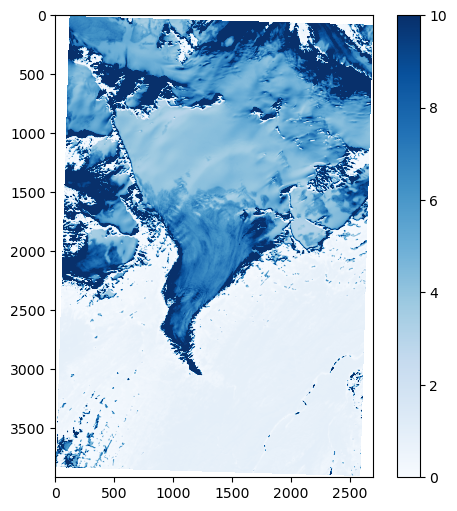

In [68]:
fig = plt.subplots(1,1,figsize=(6,6))
plt.imshow(mndsi, cmap='Blues', clim=(0,10))
plt.colorbar()
plt.show()

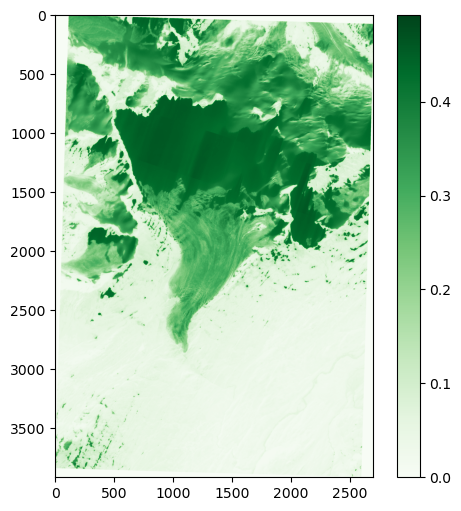

In [41]:
fig = plt.subplots(1,1,figsize=(6,6))
plt.imshow(green, cmap='Greens')
plt.colorbar()
plt.show()

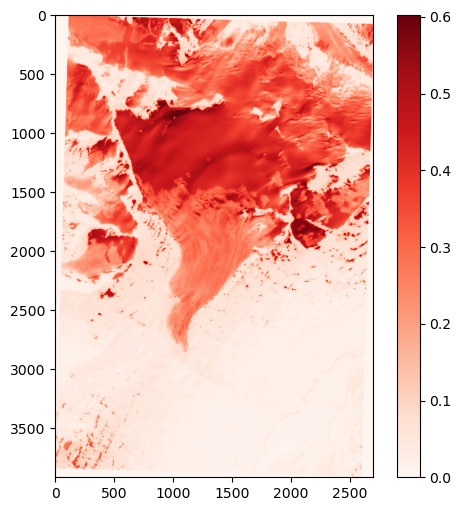

In [42]:
fig = plt.subplots(1,1,figsize=(6,6))
plt.imshow(red, cmap='Reds')
plt.colorbar()
plt.show()

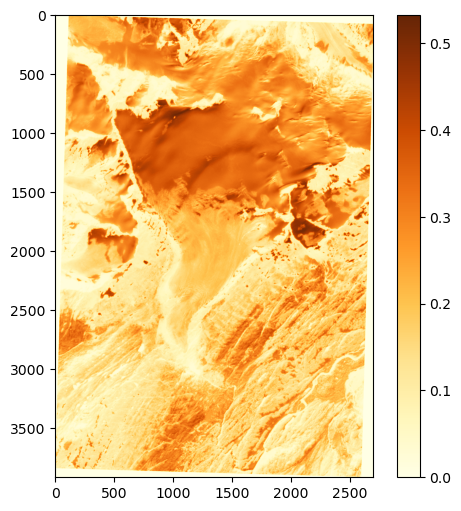

In [43]:
fig = plt.subplots(1,1,figsize=(6,6))
plt.imshow(nir, cmap='YlOrBr')
plt.colorbar()
plt.show()